In [7]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

from librep.datasets.kuhar import (
    RawKuHar,
    RawKuHarIterator,
    KuHarDatasetGenerator,
    KuHarDataset,
)

from librep.utils.dataset import load_full_data

%matplotlib inline

In [9]:
dataset_dir = Path("../data/datasets/KuHar/1.Raw_time_domain_data")
kuhar_dataset = RawKuHar(dataset_dir, download=False)
kuhar_dataset

KuHar Dataset at: '../data/datasets/KuHar/1.Raw_time_domain_data'

In [10]:
act_names = [kuhar_dataset.activity_names[i] for i in range(18)]
act_names

['Stand',
 'Sit',
 'Talk-sit',
 'Talk-stand',
 'Stand-sit',
 'Lay',
 'Lay-stand',
 'Pick',
 'Jump',
 'Push-up',
 'Sit-up',
 'Walk',
 'Walk-backwards',
 'Walk-circle',
 'Run',
 'Stair-up',
 'Stair-down',
 'Table-tennis']

In [11]:
iterator = RawKuHarIterator(kuhar_dataset)
iterator

Kuhar Iterator: users=89, activities=18

In [12]:
kuhar_v1 = KuHarDatasetGenerator(iterator, time_window=300, window_overlap=0)
kuhar_v1

Dataset generator: time_window=300, overlap=0, labels=class

In [13]:
train, validation, test = kuhar_v1.create_datasets(
    train_size=0.7,
    validation_size=0.1,
    test_size=0.2,
    ensure_distinct_users_per_dataset=True,
    balance_samples=True,
    seed=0
)

Generating full df over KuHar View: 1945it [01:29, 21.66it/s]


# Time

In [15]:
train_dataset = KuHarDataset(train, sensors=["accel-x", "accel-y", "accel-z", "gyro-x", "gyro-y", "gyro-z"], label_columns="class")
validation_dataset = KuHarDataset(validation, sensors=["accel-x", "accel-y", "accel-z", "gyro-x", "gyro-y", "gyro-z"], label_columns="class")
test_dataset = KuHarDataset(test, sensors=["accel-x", "accel-y", "accel-z", "gyro-x", "gyro-y", "gyro-z"], label_columns="class")

In [16]:
train_x, train_y = load_full_data(train_dataset, return_X_y=True)
validation_x, validation_y = load_full_data(validation_dataset, return_X_y=True)
test_x, test_y = load_full_data(test_dataset, return_X_y=True)

In [17]:
train_val_x = np.concatenate([train_x, validation_x])
train_val_y = np.concatenate([train_y, validation_y])
train_val_x.shape, train_val_y.shape

((3402, 1800), (3402,))

In [18]:
model = RandomForestClassifier()
model.fit(train_val_x, train_val_y)

RandomForestClassifier()

In [19]:
test_x.shape, test_y.shape

((432, 1800), (432,))

In [20]:
y_pred = model.predict(test_x)

In [21]:
print(classification_report(test_y, y_pred, target_names=act_names))

                precision    recall  f1-score   support

         Stand       0.57      0.71      0.63        24
           Sit       0.71      0.83      0.77        24
      Talk-sit       0.80      0.83      0.82        24
    Talk-stand       0.63      0.79      0.70        24
     Stand-sit       0.63      0.92      0.75        24
           Lay       0.86      0.50      0.63        24
     Lay-stand       0.84      0.67      0.74        24
          Pick       0.67      0.58      0.62        24
          Jump       0.74      0.96      0.84        24
       Push-up       0.77      0.71      0.74        24
        Sit-up       0.82      0.75      0.78        24
          Walk       0.68      0.71      0.69        24
Walk-backwards       0.60      0.62      0.61        24
   Walk-circle       0.68      0.96      0.79        24
           Run       0.78      0.75      0.77        24
      Stair-up       0.61      0.46      0.52        24
    Stair-down       0.40      0.08      0.14  

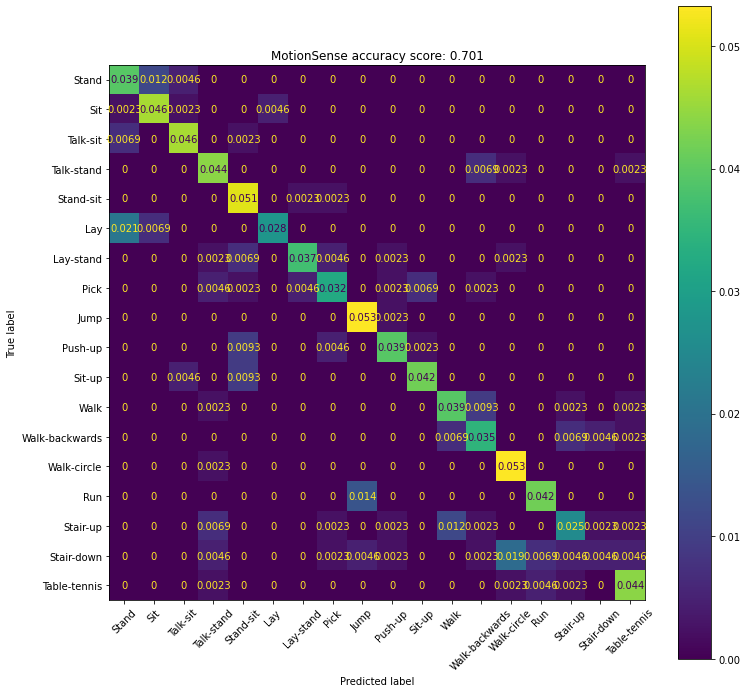

In [23]:
acc = accuracy_score(test_y, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    test_y,
    y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()

# FFT

In [24]:
from librep.utils.dataset import MultiFeatureDataset
from librep.transforms.fft import FFT
from functools import partial

features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

fft_transform = FFT()

collate_fn = np.concatenate

fft_train_dataset = MultiFeatureDataset(
    train,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

fft_validation_dataset = MultiFeatureDataset(
    validation,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

fft_test_dataset = MultiFeatureDataset(
    test,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

In [25]:
fft_train_x, fft_train_y = load_full_data(fft_train_dataset, return_X_y=True)
fft_validation_x, fft_validation_y = load_full_data(fft_validation_dataset, return_X_y=True)
fft_test_x, fft_test_y = load_full_data(fft_test_dataset, return_X_y=True)

In [26]:
fft_train_val_x = np.concatenate([fft_train_x, fft_validation_x])
fft_train_val_y = np.concatenate([fft_train_y, fft_validation_y])
fft_train_val_x.shape, fft_train_val_y.shape

((3402, 1800), (3402,))

In [27]:
model = RandomForestClassifier()
model.fit(fft_train_val_x, fft_train_val_y)

RandomForestClassifier()

In [28]:
fft_test_x.shape, fft_test_y.shape

((432, 1800), (432,))

In [29]:
fft_y_pred = model.predict(fft_test_x)

In [30]:
print(classification_report(fft_test_y, fft_y_pred, target_names=act_names))

                precision    recall  f1-score   support

         Stand       0.81      0.88      0.84        24
           Sit       0.82      0.96      0.88        24
      Talk-sit       0.96      0.96      0.96        24
    Talk-stand       0.85      0.92      0.88        24
     Stand-sit       0.96      0.92      0.94        24
           Lay       0.94      0.71      0.81        24
     Lay-stand       0.90      0.79      0.84        24
          Pick       0.69      0.92      0.79        24
          Jump       0.81      0.92      0.86        24
       Push-up       0.95      0.88      0.91        24
        Sit-up       0.96      0.92      0.94        24
          Walk       0.88      0.62      0.73        24
Walk-backwards       0.63      0.92      0.75        24
   Walk-circle       0.68      0.79      0.73        24
           Run       0.80      0.83      0.82        24
      Stair-up       0.87      0.54      0.67        24
    Stair-down       0.93      0.58      0.72  

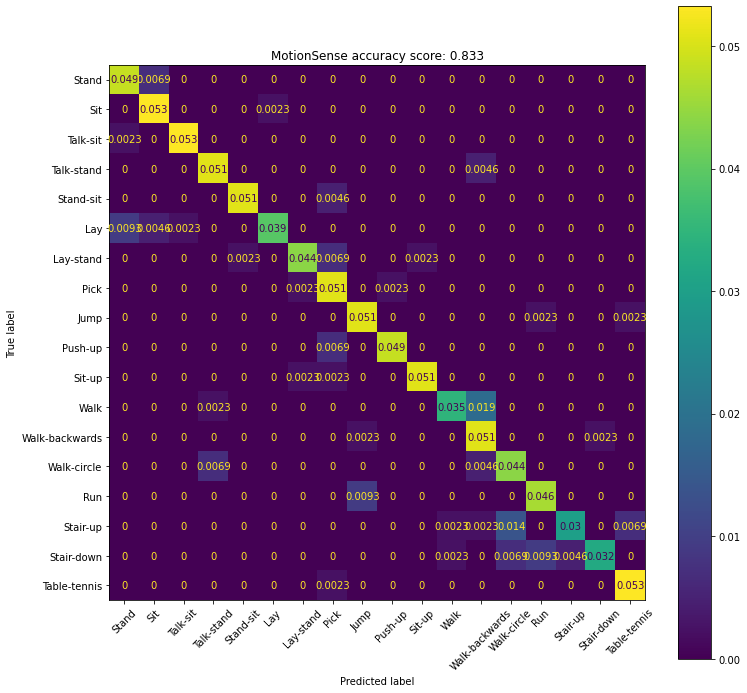

In [31]:
acc = accuracy_score(fft_test_y, fft_y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    fft_test_y,
    fft_y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()

# Fused

In [32]:
fused_train_val_x = np.concatenate([train_val_x, fft_train_val_x], axis=1)
fused_train_val_y = train_val_y
fused_train_val_x.shape, fused_train_val_y.shape

((3402, 3600), (3402,))

In [33]:
fused_test_x = np.concatenate([test_x, fft_test_x], axis=1)
fused_test_y = test_y
fused_test_x.shape, fused_test_y.shape

((432, 3600), (432,))

In [34]:
model = RandomForestClassifier()
model.fit(fused_train_val_x, fused_train_val_y)

RandomForestClassifier()

In [35]:
fused_y_pred = model.predict(fused_test_x)

In [36]:
print(classification_report(fused_test_y, fused_y_pred, target_names=act_names))

                precision    recall  f1-score   support

         Stand       0.80      0.83      0.82        24
           Sit       0.79      0.92      0.85        24
      Talk-sit       1.00      0.96      0.98        24
    Talk-stand       0.84      0.88      0.86        24
     Stand-sit       1.00      0.88      0.93        24
           Lay       0.90      0.75      0.82        24
     Lay-stand       0.88      0.92      0.90        24
          Pick       0.65      0.92      0.76        24
          Jump       0.80      1.00      0.89        24
       Push-up       1.00      0.71      0.83        24
        Sit-up       0.96      0.96      0.96        24
          Walk       0.67      0.67      0.67        24
Walk-backwards       0.66      0.88      0.75        24
   Walk-circle       0.81      0.88      0.84        24
           Run       0.85      0.92      0.88        24
      Stair-up       1.00      0.58      0.74        24
    Stair-down       0.93      0.54      0.68  

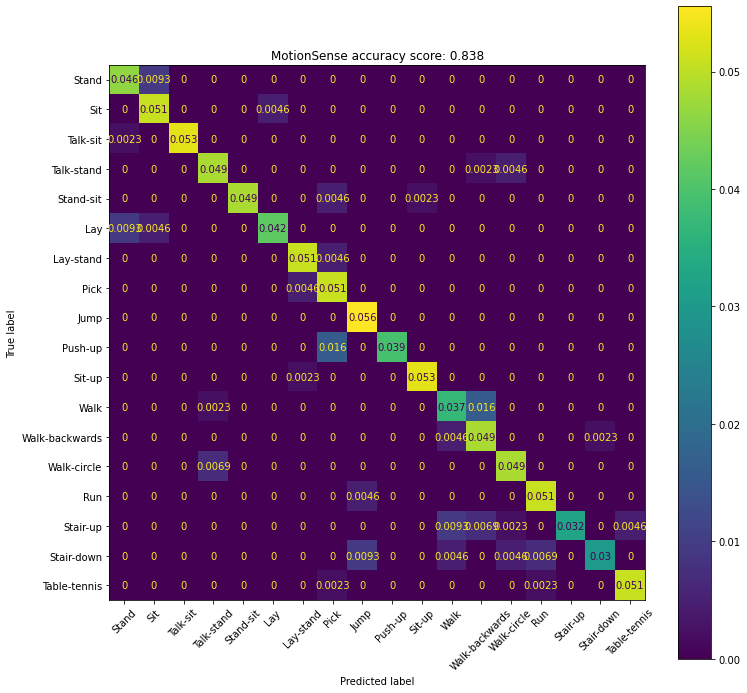

In [37]:
acc = accuracy_score(fused_test_y, fused_y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    fused_test_y,
    fused_y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()